## Load libraries and Data

In [69]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json # import json for formatting data
import os # and os for saving
import boto3
import sagemaker
from sagemaker import get_execution_role

In [84]:
# Save as Dataframe the train file and keep only Store, Dept, Sales and use Date as Index
train_file = 'data/train.csv'

train_df = pd.read_csv(train_file)
train_df['Date'] = [datetime.strptime(date, '%Y-%m-%d').date() for date in train_df['Date'].astype(str).values.tolist()]
train_df.index = train_df['Date']
train_df = train_df.drop(['Date', 'IsHoliday'], axis=1)

# take only one store for first try of training job
train_df = train_df[train_df.Store == 1]

print(train_df.tail())

            Store  Dept  Weekly_Sales
Date                                 
2012-08-31      1    99         20.06
2012-09-07      1    99          0.05
2012-09-14      1    99          0.03
2012-10-05      1    99        635.00
2012-10-12      1    99         80.00


## Plot Sales Evolution

In [82]:
# Define a function to plot sales evolution depending of the store and department number
def sales_evolution(store_number, dept_number):
    example_store_dept_sales = train_df[(train_df.Store == store_number) & (train_df.Dept == dept_number)]['Weekly_Sales']
    plt.figure(figsize=(8,3))
    example_store_dept_sales.plot(title='Store {} Dpt {} Sales evolution'.format(store_number, dept_number), color='blue') 
    return plt.show()

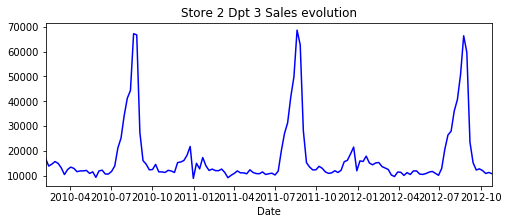

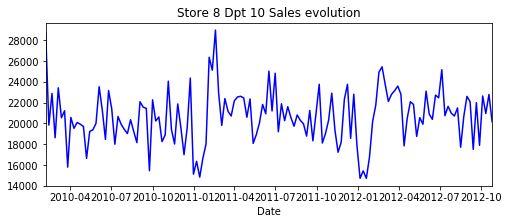

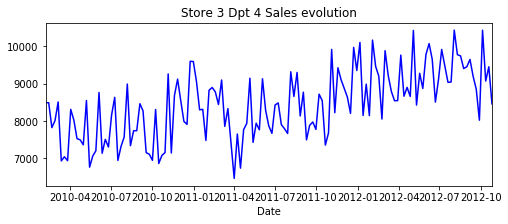

In [83]:
# Plot some examples
sales_evolution(2,3)
sales_evolution(8,10)
sales_evolution(3,4)

## Create and display complete time series

In [85]:
def make_time_series(df, years, freq='W-FRI'):
    '''Creates as many time series as they are stores x departments x complete years. 
      :param df: dataframe with train data. One 3 columns : Store, Dept, Weekly_Sales.
          This dataframe should also be indexed by a datetime.
      :param years: A list of years to make time series out of, ex. ['2010', '2011'].
      :param freq: The frequency of data recording (W-FRI = Weekly, starting on Friday)
      :return: A list of pd.Series(), time series data.
      '''
    
    # store time series
    time_series = []
    
    # create time series for each store and each department
    for store in df.Store.unique().tolist():
        for dept in df.Dept.unique().tolist():
            
            # create DataFrame with weekly_sales for the store and department studied
            sample_df = df[(df.Store == store) & (df.Dept == dept)]['Weekly_Sales']
                        
            # initialise start_idx
            start_idx = 0
            
            # create time series for each year in years
            for i in range(len(years)):

                # for each year 52 weeks (no year of 53 weeks in our dataset)
                year = years[i]
                end_idx = start_idx+52

                # create start and end datetimes
                t_start = year + '-02-05' # start with first date 
                t_end = str(int(year)+1) + '-01-28' # end friday one year later

                # get wanted sample_df data
                data = sample_df[start_idx:end_idx]

                # create time series for the year
                index = pd.date_range(start=t_start, end=t_end, freq=freq)
                Serie_df = pd.Series(data=data, index=index)
                
                # include info of the store and dept as last values to use as category in DeepAR
                Info_df = pd.Series(data=[int(store), int(dept)], index=['store','dept'])
                time_series.append(pd.concat([Serie_df, Info_df]))
                
                # start next year in loop
                start_idx = end_idx+1                
    
    # return list of time series
    return time_series

In [86]:
# Create yearly time series for our 2 complete years
full_years = ['2010', '2011']
freq='W-FRI' # weekly recordings

# make time series
time_series = make_time_series(train_df, full_years, freq=freq)

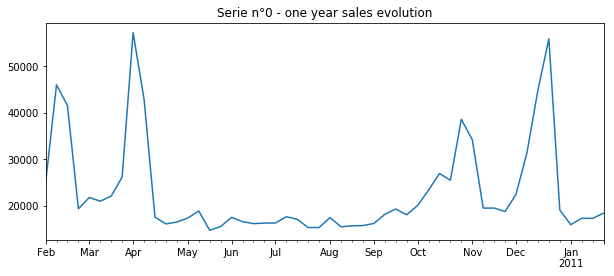

In [87]:
# display first time series
time_series_idx = 0

# plot time series except the last two values corresponding to store and department
plt.figure(figsize=(10,4))
time_series[time_series_idx][:-2].plot(title='Serie n°{} - one year sales evolution'.format(time_series_idx))
plt.show()

## Splitting in Time

In [88]:
# create truncated, training time series
def create_training_series(complete_time_series, prediction_length):
    '''Given a complete list of time series data, create training time series.
       :param complete_time_series: A list of all complete time series.
       :param prediction_length: The number of points we want to predict.
       :return: A list of training time series.
       '''
    # get training series
    time_series_training = []
    
    for ts in complete_time_series:
        
        # save store and departement number for the serie as Info
        Info_df = ts[-2:]
        
        # truncate "prediction_length" weeks + 2 corresponding to the store and departement number
        truncate = prediction_length + 2
        Train_Serie_df = ts[:-truncate]
        
        # save Train_Serie with its Info
        time_series_training.append(pd.concat([Train_Serie_df, Info_df]))
        
    return time_series_training

In [89]:
# set prediction length
prediction_length = 4 # 4 weeks ~ a month

time_series_training = create_training_series(time_series, prediction_length)

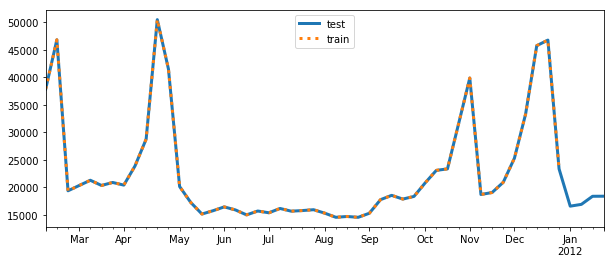

In [90]:
# display train/test time series
time_series_idx = 1

plt.figure(figsize=(10,4))
# test data is the whole time series
time_series[time_series_idx][:-2].plot(label='test', lw=3)
# train data is all but the last prediction pts
time_series_training[time_series_idx][:-2].plot(label='train', ls=':', lw=3)

plt.legend()
plt.show()

## Convert to JSON

In [91]:
def series_to_json_obj(ts):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    # get start time and target and cat from the time series, ts
    json_obj = {"start": str(ts.index[0]), "target": list(ts[:-2]), "cat": list(map(int, ts[-2:]))}
    return json_obj

In [100]:
# test out the code
ts = time_series[150]

json_obj = series_to_json_obj(ts)

print(json_obj)

{'start': '2010-02-05 00:00:00', 'target': [10891.37, 16309.73, 12087.95, 10871.74, 10903.65, 10819.46, 11323.78, 10063.69, 14740.14, 12217.58, 10791.63, 10156.01, 9845.35, 10972.91, 12519.08, 10477.58, 10033.06, 10994.44, 10784.84, 9805.78, 11254.16, 10139.42, 10987.53, 10391.77, 9980.29, 9643.04, 10210.44, 11488.27, 10160.03, 9216.01, 10282.67, 11125.38, 10745.44, 10779.14, 10344.16, 11414.81, 11695.24, 11710.03, 12769.66, 11084.68, 11433.3, 14059.26, 17693.74, 10262.38, 14341.46, 18101.81, 16795.07, 8705.87, 9419.13, 10914.54, 10329.78, 9101.75], 'cat': [1, 98]}


## Saving Data, Locally

In [101]:
def write_json_dataset(time_series, filename): 
    with open(filename, 'wb') as f:
        # for each of our times series, there is one JSON line
        for ts in time_series:
            json_line = json.dumps(series_to_json_obj(ts)) + '\n'
            json_line = json_line.encode('utf-8')
            f.write(json_line)
    print(filename + ' saved.')

In [102]:
# save this data to a local directory
data_dir = 'json_sales_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [103]:
# directories to save train/test data
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

# write train/test JSON files
write_json_dataset(time_series_training, train_key)        
write_json_dataset(time_series, test_key)

json_sales_data/train.json saved.
json_sales_data/test.json saved.


## Uploading data to S3

In [104]:
# session, role, bucket
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()

In [105]:
# general prefix
prefix='deepar-weekly-sales'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)

In [106]:
# check locations
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-eu-central-1-293973958717/deepar-weekly-sales/train/train.json
Test data is stored in: s3://sagemaker-eu-central-1-293973958717/deepar-weekly-sales/test/test.json


# Training a DeepAR Estimator

## Instantiate an Estimator

In [107]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image

In [108]:
from sagemaker.estimator import Estimator

# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

## Setting Hyperparameters

In [109]:
freq='W-FRI'
context_length=4 # same as prediction_length

hyperparameters = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

In [110]:
# set the hyperparams
estimator.set_hyperparameters(**hyperparameters)

## Training job

In [ ]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)